In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import hashlib
import pandahouse

import matplotlib.pyplot as plt


from scipy import stats

%matplotlib inline

In [4]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230520'
}


In [5]:
#Посмотрю, что по количетству данных в интересуемом временном отрезке.
q = """
SELECT uniqExact(user_id)
FROM {db}.feed_actions
WHERE toDate(time) >= '2023-04-24' and toDate(time) <= '2023-04-30'
"""

pandahouse.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,42585


In [152]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-24' and '2023-04-30'
    and exp_group in (2, 3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)


In [111]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [159]:
"""
Делаю 10к циклов, где в каждом формируется две случайные выборки объемом 500 с возвратом данных в общий пул из
экспериментальных групп 2 и 3. Сразу провожу т-тест и заношу значения а список.
"""

p_value_data=[]

for i in range (10000):
    sample_exp_group_2=df[df.exp_group==2].sample(500, replace=False)
    
    sample_exp_group_3=df[df.exp_group==3].sample(500, replace=False)
    
    p_value=stats.ttest_ind(sample_exp_group_2.ctr, sample_exp_group_3.ctr, equal_var=False)[1]
    
    p_value_data.append(p_value)

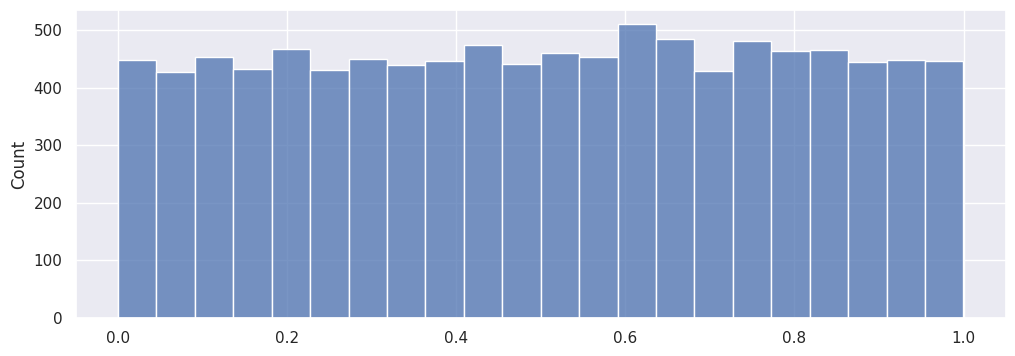

In [155]:
sns.set(rc={'figure.figsize':(12, 4)})
sns.histplot(p_value_data)
# Строю гистограмму распределения получившихся 10к p-values.

In [156]:
#Заворачиваем отобранные значения, где p_value <= 0.05 в список.
p_value_05=list(filter(lambda x: x <= 0.05,p_value_data))

In [157]:
p_value_data[1:4]

[0.9631175919625041, 0.5146264434297796, 0.88053245826093]

In [158]:
p_value_perc = sum(map(lambda item: item != 1.1, p_value_05)) / len(p_value_data) * 100
print('В',p_value_perc, '% случаев  значение p-value равно или меньше заданного уровня значимости - 0.05')

В 4.88 % случаев  значение p-value равно или меньше заданного уровня значимости - 0.05


# Выводы
###  Сравнивали 2 и 3 группы на качество сплитования и для этого использовали созданные выборки объемом 500 и пропускали через Т-тест. Результаты заносили в единый список с дальнейшей визуализацией через гистограмму которая показала равномерное распределение значений p-value.
### В менее 5% случаев p-value больше уровня значимости 0.05, а значит сплитование прошло успешно и можно переходить к А/Б тесту.
### В некоторых крутках проскакивает более 5%, но как известно если долго-долго крутить данные - всегда можно найти различия.